# Finding Fact-checkable Tweets with Machine Learning

This notebook was copied and modified from one originally created by Jeremy Howard and the other folks at [fast.ai](https://fast.ai) as part of [this fantastic class](https://course.fast.ai/). Specifically, it comes from Lesson 4. You can [see the lession video](https://course.fast.ai/videos/?lesson=4) and [the original class notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb). 

For more information about this project, and details about how to use this work in the wild, check out our [Quartz AI Studio blog post about the checkable-tweets project](https://qz.ai/?p=89).

-- John Keefe


## Using this notebook

Essentially you need a computer that's running a GPU running fast.ai. There are a few ways to do this without owning a computer with a GPU (I certainly don't). There are [lots of options](https://course.fast.ai/index.html). I like to use use [the Amazon EC2 setup](https://course.fast.ai/start_aws.html), which is probably the most complicated. In most of these cases, you'll just clone [the workshop repository](https://github.com/Quartz/aistudio-workshops) and get the notebook running.

I'm also tailoring this notebook for use with [Google Colaboratory](https://colab.research.google.com), which as of this writing is the fastest, cheapest (free) way to get going.


### If you're using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes).

There are great steps on the fast.ai site for [getting started with fast.ai an Google Colab](https://course.fast.ai/start_colab.html). 

Those instructions will show you how to save your own copy of this _notebook_ to Google Drive.

They also tell you how to save a copy of your _data_ to Google Drive (Step 4), which is unneccesary for this workshop. 

In [ ]:
## ALL GOOGLE COLAB USERS RUN THIS CELL

## This runs a script that installs fast.ai
!curl -s https://course.fast.ai/setup/colab | bash

### If you are _not_ using Google Colaboratory ...

Run the cell below.

In [3]:
## NON-COLABORATORY USERS SHOULD RUN THIS CELL
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Everybody do this ...

In [4]:
## AND *EVERYBODY* SHOULD RUN THIS CELL

from fastai.text import *

## The Plan

## The Data

In [5]:
!wget -N https://qz-aistudio-public.s3.amazonaws.com/workshops/austin_tweet_data.zip
!unzip austin_tweet_data.zip > /dev/null
print('Done!')

--2019-08-25 23:40:19--  https://qz-aistudio-public.s3.amazonaws.com/workshops/austin_tweet_data.zip
Resolving qz-aistudio-public.s3.amazonaws.com (qz-aistudio-public.s3.amazonaws.com)... 52.216.161.19
Connecting to qz-aistudio-public.s3.amazonaws.com (qz-aistudio-public.s3.amazonaws.com)|52.216.161.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 566805 (554K) [application/zip]
Saving to: ‘austin_tweet_data.zip’

austin_tweet_data.z 100%[===================>] 553.52K  --.-KB/s    in 0.01s   

2019-08-25 23:40:19 (51.8 MB/s) - ‘austin_tweet_data.zip’ saved [566805/566805]

Done!


In [6]:
%ls data

hand_coded_austin_tweets.csv  tweet_corpus.txt


### Take a peek at the tweet data

Working with Dan Keemahill and Madlin Mekelburg over a couple of weeks during the 2019 Texas state legislative session, I have have a set of 3,797 tweets humans at the Austin American-Statesman have determined are – or are not – statements that can be fact-checked. 

In [7]:
# Here I read the csv into a data frame I called `austin_tweets`
# and take a look at the first few rows
path = Path('./data')
austin_tweets = pd.read_csv(path/'hand_coded_austin_tweets.csv')
austin_tweets.head()

,Unnamed: 0,tweet_text,checkable
0,0,TOMORROW: Dallas Workers Head to TX Capitol to...,False
1,1,Texas House members told to stop secretly reco...,True
2,2,SB 1163 - Relating to establishing and funding...,False
3,3,Did you know that we’re carbon neutral* when i...,True
4,4,Check our this article on the Baylor sexual as...,False


## Building the language model

Before we make a model that classifies whether tweets are checkable, we're going to build a model that 'understands' the rules of English – the language model. 

Even several thousand tweets isn't enough to teach a computer patterns of English, so we'll start with a language model pretrained on a thousands of Wikipedia articles called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset). That language model has been trained to guess the next word in a sentence based on all the previous words. It has a recurrent structure with a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We'll take that Wikitext model and fine-tune it for our particular dataset–the #txlege tweets. Because the English of #txlege tweets isn't the same as the English of Wikipedia, we'll adjust the internal parameters of the model by a little bit. That includes adding words that might be extremely common in the tweets but would be barely present in wikipedia–and therefore might not be part of the vocabulary the model was trained on.

### Adding more tweets for the language model

We'll use the text in the 3,797 tweets we already have to help the language model better "understand" our data set. To give it even more examples, I collected several days worth of (uncategorized) #txlege tweets, which are in a file called `tweet_corpus.txt`.


In [8]:
# read in the corpus, which has one tweet per row,
# and take a look at the first frew rows
corpus_tweets = pd.read_csv(path/'tweet_corpus.txt')
corpus_tweets.head()

,tweet_text
0,State Rep. @CBellJr earned an F on this year's...
1,#txlege https://t.co/1qqa0sFEnY
2,ICYMI: @dallasnews editorial weighs in on the ...
3,My life is complete! #txlege #FlagDay #mindblo...
4,"On June 14, 1777, our nation adopted the U.S. ..."


In [9]:
# here I concatenate the two tweet sets
lm_tweets = pd.concat([austin_tweets,corpus_tweets], sort=True)

# as a sanity check, let's look at the size of each set, 
# and then the ontatenated set
len(austin_tweets), len(corpus_tweets), len(lm_tweets),

(3797, 3688, 7485)

Great: Now we have 7,485 tweets to use for the language model.

One thing to note ... the first set had two columns, `checkable` and `tweet_text`, while the corpus had just one collumn,  `tweet_text`. The combined has the original two columns, though many of the entries will be `NaN` for "not a number." Thats okay, because we're only going to use the `tweet_text` column for the language model.




In [10]:
# show the last few rows ... and we can see NaNs in the `checkable` column, 
# which is ok here because we don't use that column in the language model
lm_tweets.tail()

,Unnamed: 0,checkable,tweet_text
3683,NaN,NaN,From our friends at @ProgressTX: One of the to...
3684,NaN,NaN,@GregAbbott_TX The Texas House failed Texans. ...
3685,NaN,NaN,Good to see one recommendation from Gov. Abbot...
3686,NaN,NaN,Our executive director @antgutierrez spoke to ...
3687,NaN,NaN,NaN


In [11]:
# But we can't have NaN in the 'tweet_text' column, because it will make things unhappy.
# Let's fix that:
lm_tweets.dropna(subset=['tweet_text'], inplace=True)

# Saving as csv for easier reading in a moment
lm_tweets.to_csv(path/'lm_tweets.csv')

Fast.ai uses a concept called a "[data bunch](https://docs.fast.ai/basic_data.html)" to handle machine-learning data, which takes care of a lot of the more fickle machine-learning data preparation.

We have to use a special kind of data bunch for the language model, one that ignores the labels, and will shuffle the texts at each epoch before concatenating them all together (only the training set gets shuffled; we don't shuffle for the validation set). It will also create batches that read the text in order with targets (aka the best guesses) that are the next word in the sentence.


In [12]:
# Loading in data with the TextLMDataBunch factory class, using all the defaults
data_lm = TextLMDataBunch.from_csv(path, 'lm_tweets.csv', text_cols='tweet_text', label_cols='checkable')
data_lm.save('data_lm_tweets')

### Quick digression: Let's look at the data

The data bunch function does some nifty things behind the scenes. Let's take a moment to look at what is happening. (This is optional, but interesting!)


#### Tokenization

The first step of processing is to split the raw tweets into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but fast.ai is smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [13]:
# Note that language models can use a lot of GPU, here
# If you're not using Google Colab you may need to decrease batch size
bs=48
data_lm = load_data(path, 'data_lm_tweets', bs=bs)
data_lm.show_batch()

idx,text
0,"xxmaj cornyn is a racist bigot who has dementia . xxmaj we are not in 1940s , commie xxmaj cornyn ! # txlege xxbos xxmaj true education is about relationships ... xxmaj simple way to “ test ” that — > 👍 or 👎 . # txed # txlege https : / / t.co / xxunk xxbos xxunk awards school districts in need with grants to help students achieve their"
1,"our nation 's history - b / c it 's a terrible idea with no clearly defined rules # txlege xxbos @gregabbott_tx xxmaj likewise clearing xxunk rape tests can eliminate innocent men xxunk accused . xxmaj then the actual xxunk is run to ground and prosecuted . xxmaj thanks to # txlege for getting this dome . xxmaj and gov xxmaj abbott for signing , xxbos xxmaj nice to see"
2,"with families against xxup sb 4 . # txlege xxbos 86th xxmaj leg xxmaj stats time . xxup xxunk xxmaj stat xxmaj rpt has xxunk bills passing , xxmaj leg xxmaj reference xxmaj library xxmaj rpt has xxunk , and xxmaj xxunk xxmaj stat xxmaj rpt has 1,184 . xxmaj all agree on xxunk bills filled . xxmaj my search has 1,184 . xxmaj so going with the 16 %"
3,"texas xxmaj house just passed xxup hb1936 from @reptonirosetx that restricts use of the death penalty for people with severe mental illness , instead giving them life in prison without xxunk . \n \n xxmaj rose asks her colleagues to “ be pro - life from the womb to the tomb . ” # txlege xxbos @sarahforhd134 xxmaj way to go , congrats ! xxmaj the # xxunk will"
4,"the face of renewed public opposition to xxmaj confederate monuments , several xxmaj southern states have passed laws making it extremely difficult to remove historical monuments . \n \n https : / / t.co / oap0hd8sov # txlege xxbos xxmaj abigail xxmaj xxunk : xxmaj we 're in a data - driven age and we 've got to get serious about how we use that data to improve things"


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

#### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [14]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [15]:
data_lm.train_ds[1][0]

Text xxbos xxunk # sarahfabianisamonster # sarahfabianisagarbageperson # trumptortureschildren # trumpconcentrationcamps # trumpisaracist xxmaj john xxmaj cornyn is a racist bigot who has dementia . xxmaj we are not in 1940s , commie xxmaj cornyn ! # txlege

But the underlying data is all numbers

In [16]:
data_lm.train_ds[1][0].data[:10]

array([   2,    0,   10, 4165,   10, 4166,   10, 4167,   10, 2974])

### Back to making the Language Model

We can then put all of our tweets (now stored in `data_lm`) in a learner object very easily with the Wikitext model loaded with the pretrained weights (here called `AWD_LTSM`). They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/`

In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

One of the most important settings when we actually _train_ our model is the **learning rate**. I'm not going to dive into it here (though I encourage you to explore it), but will use a fast.ai tool to find the best learning rate to start with:

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


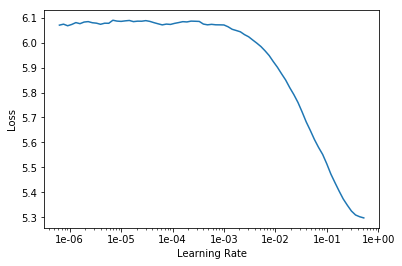

In [20]:
learn.recorder.plot(skip_end=15)

This gives us a graph of the optimal learning rate ... which is the point where the graph really dives downward (`1e-02`). Again, there's much more on picking and learning rates in the fast.ai course.

Now we can train the Language Model. (Essentailly, we're training it to be good at guessing the *next word* in a sentence, given all of the previous words.)

The variabales we're passing are `1` to just do one cycle of learning, the learning rate of `1e-2`, and some momentum settings we won't get into here -- but these are pretty safe. 

In [21]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.211631,3.573457,0.369142,00:25


In [19]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,3.981636,3.663427,0.369721,00:25


In [0]:
# optionally save and reload the model (file is about 150MB)
learn.save('fit_head')
learn.load('fit_head');

To complete the fine-tuning, we "unfreeze" the original Wikitext language model and let the new training efforts -- work their way into the original neural network.

In [22]:
# This takes a couple of minutes!
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.420573,3.316068,0.400783,00:31
1,3.179419,3.185807,0.417638,00:31
2,2.848459,3.160211,0.423794,00:31
3,2.583529,3.180158,0.422932,00:31


In [23]:
# optionally save what we have - file is about 300MB
learn.save('fine_tuned')

While our accuracy may _seem_ low ... in this case it means the language model correctly guessed the next word in a sentence more than 1/3 of the time. That's pretty good! And we can see that even when it's wrong, it makes some pretty "logical" guesses. 

Let's give it a starting phrase and see how it does:


In [24]:
TEXT = "I wonder if this"
N_WORDS = 40
N_SENTENCES = 3

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I wonder if this is Texas ' # gun ban ? # txlege # txed https : / / t.co / Scheduling God xxbos If you already know who is serving ! we need to know where we are .
I wonder if this bill happened in Texas or in the Woodlands , Texas , with a population of over 2.6 . # txlege xxbos Texas House 
  https : / / t.co / team xxbos Been a
I wonder if this is the last time a Texas legislator has been arrested for using an auto - parts to improve school safety . # txlege xxbos Save # txlege companies & & property tax reform at # txlege all over


Remember, these are not real ... they were _generated_ by the model when it tried to guess each of the next words in the sentence! Generating text like this is not why we made the language model (though you can see where text-generation AI starts from!)

Also note that the model is often crafting the response _in the form of a tweet!_

We now save not only the model, but also its encoder, which is the mathematical representation of what the language model "understands" about English patterns.

In [25]:
learn.save_encoder('fine_tuned_enc')  

## Building the classifier model

This is the model that will use our langauge model **and** the hand-coded tweets to guess if new tweets are fact-checkable or not.

We'll create a new data bunch that only grabs the hand-coded tweets and keeps track of the labels there (true or false, for fact-checkability). We also pass in the `vocab` -- which is the list of the most useful words from the language model.

In [26]:
data_clas = TextClasDataBunch.from_csv(path, 'hand_coded_austin_tweets.csv', vocab=data_lm.vocab, text_cols='tweet_text', label_cols='checkable')

data_clas.save('data_clas_tweets')

And here's how the computer has tokenized the tweets:

In [27]:
data_clas.show_batch()

text,target
"xxbos xxmaj house : \n * xxmaj huberty ( r - xxmaj houston ) , chair \n * xxmaj xxunk ( r - xxmaj xxunk ) \n * xxmaj bernal ( d - xxmaj san xxmaj antonio ) \n * xxmaj gonzalez ( d - xxmaj el xxmaj paso ) \n * xxmaj king ( r - xxmaj xxunk ) \n xxmaj senate :",False
xxbos # xxunk xxmaj baseball xxmaj xxunk : xxmaj april 8th \n \n 2 . xxmaj kirbyville xxmaj wildcats \n xxmaj record : ( 16 - 6 - 1 ) xxmaj last xxmaj week : # 3 \n \n 4 . xxmaj hardin - xxmaj jefferson xxmaj xxunk \n xxmaj record : ( 12 - 8 ) xxmaj last xxmaj week : # 8 \n \n,False
xxbos ( xxmaj there were items on it in xxup ut / xxup tt poll : https : / / texaspolitics.utexas.edu / blog / peculiar - partisan - patterns - persist - lukewarm - views - constitutional - revision … ) xxup tx xxmaj senate passes convention of states bills . https : / / www.texastribune.org / 2017 / 02 / 28 / convention - states - legislation -,False
xxbos xxmaj on our way back to xxmaj south xxmaj carolina . xxmaj hope to see you in : \n 🚙 xxmaj bluffton today at 5 ( xxup xxunk xxunk xxmaj middle xxmaj school xxmaj gym ) \n 🚙 xxmaj ladson xxmaj saturday at 9:30 ( xxmaj xxunk 's xxmaj xxunk xxmaj restaurant ) \n 🚙 xxmaj denmark xxmaj saturday at 3 ( xxmaj massachusetts xxmaj hall,False
"xxbos xxmaj in one week ! \n \n xxmaj join us , artist xxmaj xxunk , and the xxup sa xxmaj food xxmaj bank ( @safoodbank ) for our xxmaj xxunk xxmaj medal xxmaj food xxmaj drive . xxmaj april 20th . xxup 10am . xxmaj park xxmaj north xxmaj xxunk parking lot . ( xxmaj bring food you would actually eat . xxmaj no cans of xxunk xxunk",False


We can then create a model to classify tweets. You can see that in the next two lines we include the processed, hand-coded tweets (`data_clas`), the original Wikitext model (`AWD_LSTM`), and the knowledge we saved after infusing the language model with tweets (`fine_tuned_enc`).

In [28]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3037 items)
x: TextList
xxbos xxmaj after a couple short - term xxunk , xxmaj kacal has now pushed the bail bill back until tomorrow morning . # txlege,xxbos xxmaj her : xxmaj it ’s hard for me to open up to someone again . 
 
  xxmaj me : xxmaj you can let your guard down , cause i ’m your guard now !,xxbos xxmaj what does this mean for local taxpayers ? xxmaj local taxpayers will pick up even larger amount of the bill for facilities debt . # txlege # txed,xxbos @scottbraddock xxmaj my view https : / / t.co / xxunk,xxbos xxmaj booming xxmaj oil & & xxmaj gas xxmaj help xxmaj texas xxmaj xxunk xxmaj grow 3 xxmaj times xxmaj faster xxmaj than xxup u.s. xxmaj average https : / / t.co / xxunk # txlege
y: CategoryList
False,False,False,False,False
Path: data;

Valid: LabelList (760 items)
x: TextList
xxbos xxmaj live drawing by xxunk of yesterday 's public hearing on xxup hb xxunk https : / / t.co / xxunk creating a criminal offense for

Again, we need to find the best learning rate, where the slope starts to drop ...

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


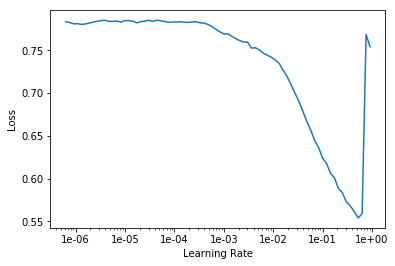

In [30]:
learn.recorder.plot()

Again, we're using the point where the learning rate slopes down to train our model -- here `1e-2`. We're also using "momentums" which we'll get into another time.

In [31]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.353356,0.229632,0.922368,00:05


Nice accuracy! We can still do more training ... partly because the validation loss is still less than the training loss. Also we freeze the model except the last layer using `freeze_to(-2)`

In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.230969,0.206276,0.934211,00:06


Better! But looks like we can do more.

In [33]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.178771,0.193025,0.928947,00:09


Can we do even better?

In [34]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.139325,0.191189,0.932895,00:14
1,0.127208,0.190560,0.935526,00:14


I'll take 93% accuracy! Let's give it an example ....

In [35]:
learn.predict("Four states have two universities represented in the top 20 highest-paid executives of public colleges. Texas has SIX")

(Category True, tensor(1), tensor([0.0018, 0.9982]))

`True` means checkable! Let's save our work.

In [36]:
# optional save, about 300 MB
learn.save('pretty_good_model')

## Preparing for Using Render

We could stop here and use this model to guess thousands of saved, unchecked tweets. But I wanted to put this in the wild -- watching for new tweets and sending a Slack message when it spotted a fact-checkable tweet. For that, I hosted the predictor on a service called [Render](https://render.com).

My Render code, [which is in this repository](https://github.com/jkeefe/nlp-classifier-fastai-render), needs access to the model and all of its details. So I exported it here, and saved it to a public spot on the internet. 

The next line (which is optional) will save everything we need for predictions to a ~90MB file to your Google Drive.

In [0]:
## optional save as `export.pkl`  - about 90 MB
learn.export()

For more about deploying a predictor on Render, see our [blog post about building the checkable-tweets project](https://qz.ai/?p=89).